In [1]:
import torch
from torch import nn
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# 使用块的网络（VGG）


## VGG发展

- LeNet (1995)
    - 2卷积＋池化层＋2全连接层

- AlexNet
    - 更大更深, ReLu, Dropout,数据增强.

- VGG
    - 更大更深的AlexNet(重复的VGG块)


<img src='../img/6_convolutional_neural_networks/nets_performance.png'>

来源：https://cv.gluon.ai/model_zoo/classification.html

## VGG块

- 深vs.宽?
    - 深但窄效果更好
- 卷积核大小？
    - 5x5卷积
    - 3x3卷积
- VGG块
    - 3x3卷积（填充1）（n层, m通道）
    - 2x2最大汇聚层（步幅2）


<center><img src='../img/6_convolutional_neural_networks/vggblock.png' width=80%></center>

In [1]:
def vgg_block(num_convs, in_channels, out_channels):
    """vgg块"""
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels,
                                kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

# VGG网络

## VGG架构


- 多个VGG块后接全连接层
- 不同次数的重复块得到不同的架构，例如VGG-16，VGG-19，.....


<center><img src='../img/6_convolutional_neural_networks/vggstruct.png' width=60%></center>

In [3]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512)) # (卷积层个数，输入通道数)

def vgg(conv_arch):
    """建立vgg网络"""
    conv_blks = []
    in_channels = 1
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels

    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 10))

net = vgg(conv_arch)

- 观察每个层输出的形状

In [4]:
X = torch.randn(size=(1, 1, 224, 224))
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__,'output shape:\t',X.shape)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


- 由于VGG-11比AlexNet计算量更大，因此构建一个通道数较少的网络

In [5]:
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch)

## 模型训练

In [ ]:
import sys
sys.path.append('/home/teaching/slides/deeplearning/3_linear_network')
sys.path.append('/home/teaching/slides/deeplearning/6_convolutional_neural_networks')
# 将load_data_fashion_mnist函数所在路径加入系统环境变量路径中

from softmax_regression_scratch import load_data_fashion_mnist, Accumulator, Animator, accuracy
from convolution_LeNet import train_ch6, try_gpu

loss 0.177, train acc 0.934, test acc 0.911
2562.3 examples/sec on cuda:0


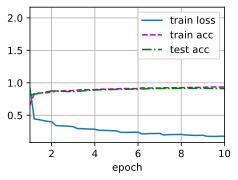

In [6]:
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = load_data_fashion_mnist(batch_size, resize=224)
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

总结

- VGG使用可重复使用的卷积块来构建深度卷积神经网络
- 不同的VGG模型可通过每个块中卷积层数量和输出通道数量的差异来定义
